# Training the CNN Model

We run this notebook to train the CNN model.  Most of the nitty gritty stuff is stowed away in python files such as reading in the dataset and converting it to a tensorflow Dataset object.  For more information, make sure to check out the documentation in `chandra.models.cnn`!

In [1]:
from galaxyteam.models import cnn_with_TL
from matplotlib import pyplot as plt
from keras.models import load_model
from galaxyteam.metrics import F1_Score

In [18]:
history, model = cnn_with_TL.train_TL(epochs=25, batch_size=128)

Epoch 1/25
30/30 [==============================] - ETA: 0s - loss: 71.4302 - recall: 0.7459 - precision: 0.7434 - f1_score: 0.7446 

c:\Users\karth\anaconda3\envs\chandra\lib\site-packages\keras-2.9.0-py3.9.egg\keras\engine\training.py:2086: UserWarning: Metric F1_Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


30/30 [==============================] - 745s 24s/step - loss: 71.4302 - recall: 0.7459 - precision: 0.7434 - f1_score: 0.7446 - val_loss: 27.9536 - val_recall: 1.0000 - val_precision: 0.7270 - val_f1_score: 0.8419
Epoch 2/25
30/30 [==============================] - 866s 29s/step - loss: 17.3653 - recall: 0.7882 - precision: 0.7932 - f1_score: 0.7907 - val_loss: 12.1188 - val_recall: 1.0000 - val_precision: 0.7356 - val_f1_score: 0.8477
Epoch 3/25
30/30 [==============================] - 868s 29s/step - loss: 4.6858 - recall: 0.8169 - precision: 0.8119 - f1_score: 0.8144 - val_loss: 0.6891 - val_recall: 0.9485 - val_precision: 0.8485 - val_f1_score: 0.8957
Epoch 4/25
30/30 [==============================] - 869s 29s/step - loss: 0.4454 - recall: 0.8766 - precision: 0.8655 - f1_score: 0.8710 - val_loss: 0.2933 - val_recall: 0.8645 - val_precision: 0.9592 - val_f1_score: 0.9094
Epoch 5/25
30/30 [==============================] - 868s 29s/step - loss: 0.3664 - recall: 0.8884 - precision: 

## Plotting the Training Performance

Text(0, 0.5, 'F1 Score')

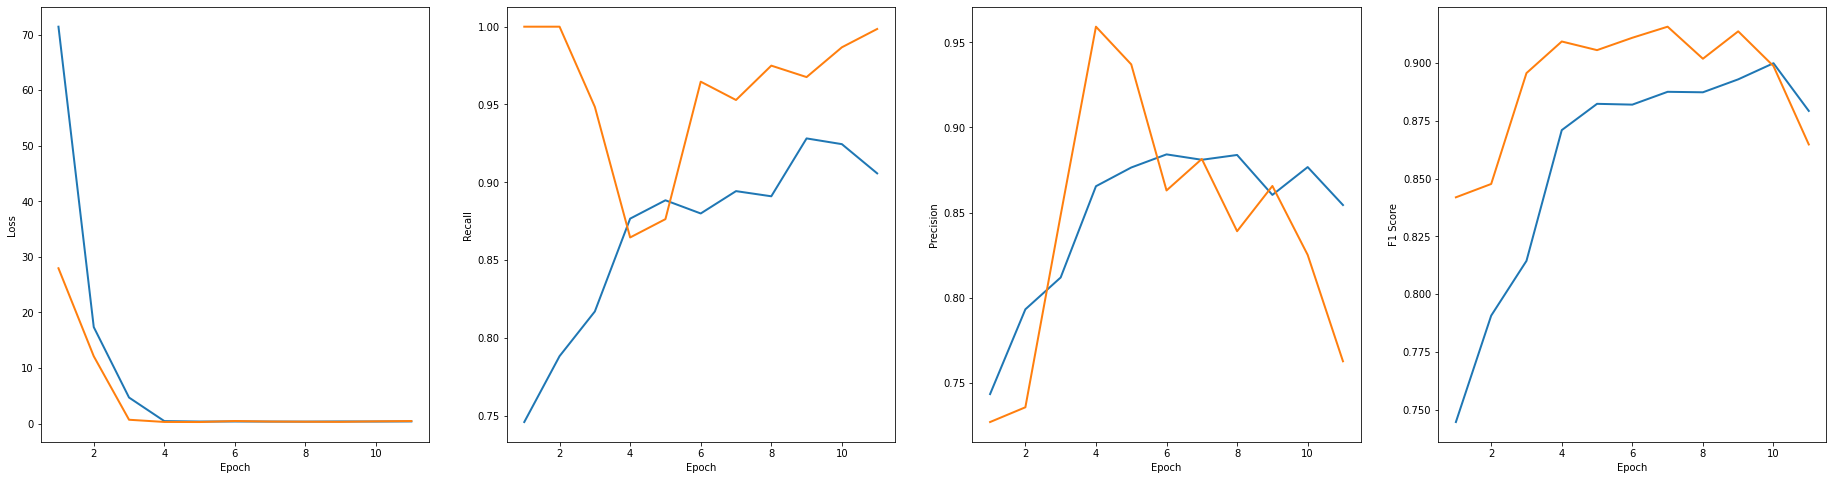

In [19]:
fig = plt.figure(figsize=(32, 8))
sp1 = fig.add_subplot(141)
sp2 = fig.add_subplot(142)
sp3 = fig.add_subplot(143)
sp4 = fig.add_subplot(144)

num_epochs = range(1, len(history.history['loss'])+1)

sp1.plot(num_epochs, history.history['loss'], linewidth=2, label='Train')
sp1.plot(num_epochs, history.history['val_loss'], linewidth=2, label='Val')

sp2.plot(num_epochs, history.history['recall'], linewidth=2, label='Train')
sp2.plot(num_epochs, history.history['val_recall'], linewidth=2, label='Val')

sp3.plot(num_epochs, history.history['precision'], linewidth=2, label='Train')
sp3.plot(num_epochs, history.history['val_precision'], linewidth=2, label='Val')

sp4.plot(num_epochs, history.history['f1_score'], linewidth=2, label='Train')
sp4.plot(num_epochs, history.history['val_f1_score'], linewidth=2, label='Val')

sp1.set_xlabel('Epoch')
sp1.set_ylabel('Loss')

sp2.set_xlabel('Epoch')
sp2.set_ylabel('Recall')

sp3.set_xlabel('Epoch')
sp3.set_ylabel('Precision')

sp4.set_xlabel('Epoch')
sp4.set_ylabel('F1 Score')

## Saving the Trained Model

In [20]:
model.save('TL_v2')

INFO:tensorflow:Assets written to: TL_v2\assets


INFO:tensorflow:Assets written to: TL_v2\assets


In [2]:
model = load_model('TL_v2', custom_objects={'F1_Score':F1_Score})

In [5]:
import tensorflow as tf
tf.__version__

'2.9.0'

## Fine Tune the Model Fit

Unfortunately, we ran out of computing time for this project and were not able to perform the fine tuning.  Our plan was to unfreeze the RESNET model and continue training on the x-ray data with a very low learning rate to allow for fine tuning of the convolutional layers

In [5]:
history_ft, model_ft = cnn_with_TL.train_TL(finetune=True, batch_size=128)

Epoch 1/10


: 

: 

In [ ]:
fig = plt.figure(figsize=(32, 8))
sp1 = fig.add_subplot(141)
sp2 = fig.add_subplot(142)
sp3 = fig.add_subplot(143)
sp4 = fig.add_subplot(144)

num_epochs = range(1, len(history.history['loss'])+1)

sp1.plot(num_epochs, history.history_ft['loss'], linewidth=2, label='Train')
sp1.plot(num_epochs, history.history_ft['val_loss'], linewidth=2, label='Val')

sp2.plot(num_epochs, history.history_ft['recall'], linewidth=2, label='Train')
sp2.plot(num_epochs, history.history_ft['val_recall'], linewidth=2, label='Val')

sp3.plot(num_epochs, history.history_ft['precision'], linewidth=2, label='Train')
sp3.plot(num_epochs, history.history_ft['val_precision'], linewidth=2, label='Val')

sp4.plot(num_epochs, history.history_ft['f1_score'], linewidth=2, label='Train')
sp4.plot(num_epochs, history.history_ft['val_f1_score'], linewidth=2, label='Val')

sp1.set_xlabel('Epoch')
sp1.set_ylabel('Loss')

sp2.set_xlabel('Epoch')
sp2.set_ylabel('Recall')

sp3.set_xlabel('Epoch')
sp3.set_ylabel('Precision')

sp4.set_xlabel('Epoch')
sp4.set_ylabel('F1 Score')